# Trip planning recommender

This notebook is to build a trip planning recommender that suggests traveling areas to travelers. The suggesting areas are concentrated with attractive and functional venues of the travelers’ need. 

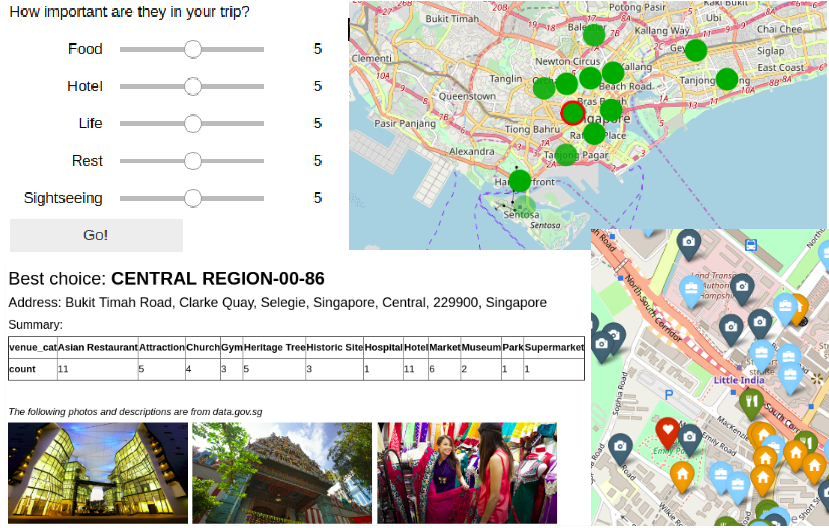

In [1]:
##### Libraries #####
import os, re, folium, requests, time, warnings
import numpy as np
import pandas as pd
import matplotlib.path as mplPath
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
from math import sin, cos, sqrt, atan2, radians
from ipywidgets import Checkbox, Button, VBox, HTML, Output, IntSlider
from xml.dom.minidom import parse
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from IPython.display import clear_output

##### Constants #####
# Area radius
RADIUS = 500

##### Helper functions #####
def parseVertices(v):
    v = v.lstrip(' ')
    latlng = np.array([[float(p.split(',')[1]), float(p.split(',')[0])] for p in v.split(' ')])
    return ( mplPath.Path(latlng), np.mean(latlng, axis=0), np.min(latlng, axis=0), np.max(latlng, axis=0) )

def distance(loc1, loc2):
    lat1, lng1, lat2, lng2 = list(map(radians, [loc1[0], loc1[1], loc2[0], loc2[1]]))
    a = sin( (lat2-lat1)/2 )**2 + cos(lat1) * cos(lat2) * sin( (lng2-lng1)/2 )**2
    return 2 * 6373. * 1000 * atan2(sqrt(a), sqrt(1 - a))

def descfunc1(e):
    return {row.find_all()[0].text: row.find_all()[1].text
        for row in BeautifulSoup(e, 'html.parser').find('table').find('table').find_all('tr') }

def descfunc2(e):
    return {row.find_all()[0].text: row.find_all()[1].text
        for row in BeautifulSoup(e, 'html.parser').find('table').find_all('tr') }

def corrfunc1(e):
    return {'venue_lng':float(e.split(',')[0]),'venue_lat':float(e.split(',')[1])}

def mergeDict(a, b):
    a.update(b)
    return a

def divide(a,b):
    return 1 if a==0 and b==0 else None if b== 0 else a/b

def normalize(series, importance):
    def linear(series, cutoff):
        return pd.Series([divide(min(x,cutoff),cutoff) for x in series], index=series.index)

    cutoff = series[series>0].quantile(importance/10) if len(series[series>0]) else 0
    return importance * linear(series, cutoff)

def pairup(loc1):
    for name, loc2 in zip(names, locs):
        if distance(loc1, loc2) < RADIUS:
            return pd.Series({'name':name,'lat':loc2[0],'lng':loc2[1]})
    return pd.Series({'name':np.nan,'lat':np.nan,'lng':np.nan})

def getAddress(loc):
    geolocator = Nominatim(user_agent="trip_planning_recommender__")
    while True:
        try:
            return geolocator.reverse(loc).address
        except Exception as e:
            time.sleep(0.5)

def randColor(n):
    colors = []
    np.random.seed(2)
    while len(colors) < n:
        cand = np.random.randint(0,255,3)
        if any([ch<30 for color in colors for ch in np.abs(color-cand)]):
            continue
        colors.append(cand)
    return ['#%02x%02x%02x'%tuple(color) for color in colors]
            
def randColor2(n):
    options = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
             'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
    np.random.seed(2)
    np.random.shuffle(options)
    return options[:n]

def getAlbumHtml(pictDF):
    pictDF = pictDF.sample(frac=1)
    album_html = ''
    for i, row in pictDF.reset_index(drop=True).iterrows():
        if i%3==0: 
            album_html += '<tr>'
        album_html += '''<td width=240 valign="top">
                         <img src="%s" height=180 width=240><br><font size=2>%s</font></td>'''\
                        %(row['PhotoURL'], row['Description'])
        if i%3==2:
            album_html += '</tr>'
        if i == 8:
            break
    return album_html

# Data collection - area candidates

  We need a list of circular area candidates to choose from in order to make recommendations.
  
  Each candidate is represent by a point, which is generated by:
  
  1. Sample random points in Singapore (Central, East regions);
  2. Reject a point if a new area is overlapped with existings.


In [2]:
##### Get geo polygons that defines Singapore's boundaries
##### The polygons is used for generating random points.
##### Return a dict of {region_name: (polygon, center_latlng, upperleft_latlng, lowerright_latlng)}

polykml = './data.gov.sg/regions/master-plan-2014-region-boundary-web/MP14_REGION_WEB_PL.kml'
polys   = {pm.getElementsByTagName('name')[0].firstChild.data: 
              [parseVertices(ob.getElementsByTagName('coordinates')[0].firstChild.data )
                  for ob in pm.getElementsByTagName('outerBoundaryIs')]
                      for pm in parse(polykml).getElementsByTagName('Placemark')}

##### Generate a list of areas

# Set seed
np.random.seed(2)
names, locs, streets = [], [], []
                
# loop over all regions. Each region can have more than one polygon.
for name,  regions in polys.items():
    # Confine regions
    if name not in ['CENTRAL REGION', 'EAST REGION', 'NORTH REGION']:
        continue
        
    # keep generating until no new valid points
    for i, (poly, center, ul, br) in enumerate(regions):
        donecnt = 0
        failcnt = 0
        while failcnt < 2000:
            sample = [np.random.uniform(ul[0],br[0]), np.random.uniform(ul[1],br[1])]
            
            # test if it is a valid new point. If not, failcnt increments and finally ends the loop
            if poly.contains_point(sample) and not any([distance(loc,sample)<2*RADIUS for loc in locs]):
                names.append('%s-%02d-%02d'%(name,i,donecnt))
                locs.append(sample)
                streets.append(getAddress(sample))
                donecnt += 1
            else:
                failcnt += 1

In [3]:
##### Plot all candidates out

# get center latlng
centerLoc = np.mean(locs, axis=0)

# create map and add marks for areas
mapArea = folium.Map(location=centerLoc, zoom_start=11)
for name, street, loc in zip(names, streets, locs):
    folium.Circle(loc, RADIUS, name, street, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7)\
          .add_to(mapArea)  
display(mapArea)

# Data collection - Venues near areas from FourSquare API

  Now that we have a list of areas, we query venues near each area.
  
  1. Begin with getting venue category definitions of the API;
  2. We limit to use a small group of categories as there is query limitation
  

In [4]:
CLIENT_ID     = 'AYZYQLIYYKRRE4X3FLPAQVZYVY3YDRAAP5XFI2FYG2BWMRVM' # Foursquare ID
CLIENT_SECRET = 'L3WZNFI0BOIEAW4Z2S25ADX12XBSLT53Z1HGHY2T5P14IZPD' # Foursquare Secret

##### Get category definitions. The API returns a JSON, from which we get a list of paths
##### Each path describes a final category and its parent categories.
##### /<Cat ID>:<Cat Name>/<...>/<Cat ID>:<Cat Name>

url  = ''.join(['https://api.foursquare.com/v2/venues/categories?&client_id=',CLIENT_ID,'&client_secret=',CLIENT_SECRET,'&v=20180605'])
tmps = [('',requests.get(url).json()['response']['categories'])]

# cNID collects all paths
cNID = []
while tmps:
    path, tmp = tmps.pop()
    for t in tmp:
        cat  = t.get('categories',[])
        path = '%s//%s:%s'%(path, t.get('id','_'), t.get('name','_'))
        if cat:
            tmps.append((path, cat))
        else:
            cNID.append( path)

# categories of interest
cats = ['American Restaurant','Basketball Court','Church','Bank','Café','Gym',
        'Asian Restaurant','Supermarket','Shopping Mall','Laundry Service','Market','Hospital',]

# category map that maps child category names to categories of interest
cmap = { level.split(':')[-1]:cat
            for cat in cats 
                for nid in cNID if re.match('.*:%s$'%cat, nid) or re.match('.*:%s//'%cat, nid)
                       for level in re.split(':%s', nid)[-1].split('//')}

# a list of category IDs 
cids = [nid.split('//')[-1].split(':')[0] for cat in cats for nid in cNID if re.match('.*:%s$'%cat, nid)]

##### Helper function: getNearbyVenues
##### It loops through areas and obtain nearyby venues of category of interest

def getNearbyVenues(names, locs, radius=RADIUS):
    venues=[]
    for name, (lat, lng) in zip(names, locs):
        nCalls = 2 # divide one call into two
        for j in range(nCalls): 
            size = int(np.ceil(len(cids)/nCalls))
            cid = ','.join(cids[j*size:(j+1)*size])
            
            url = ['https://api.foursquare.com/v2/venues/explore?&client_id=',CLIENT_ID,'&client_secret=',CLIENT_SECRET,
                   '&v=20180605','&ll=',lat,',',lng,'&radius=',radius,'&limit=500','&categoryId=',cid]
            url = ''.join([str(x) for x in url])
            for i in range(10):
                try:
                    results = requests.get(url).json()["response"]['groups'][0]['items']
                    break
                except:
                    print('retrying', i)

            venues.extend([{'name':name,'lat':lat,'lng':lng,
                            'venue':v['venue']['name'],
                            'venue_lat':v['venue']['location']['lat'],
                            'venue_lng':v['venue']['location']['lng'],
                            'venue_cat':v['venue']['categories'][0]['name']} for v in results])
    return pd.DataFrame(venues)

# get nearby venues
print('# regions', len(names))
venues = getNearbyVenues(names, locs)

# map names
venues['venue_cat'] = venues['venue_cat'].replace(cmap)
venues = venues[venues['venue_cat'].isin(cats)]
venues = venues.merge(pd.DataFrame({'name':names,'address':streets}), on='name', how='left')

# regions 259


# Data collection - Venue data from data.gov.sg

  data.gov.sg offers datasets for attraction spots, hotels and so on with photo URLs and other useful attributes.
  
  Here we will load 7 download datasets, for hotels, attractions, museums, heritage trees, heritage sites, libraries, and parks.

In [5]:
##### Helper function: parseKML()
def parseKML(cat, kml):
    try:
        desc = [descfunc1(e.text) for e in ET.parse(kml).getroot().iter() if 'description' in e.tag]
    except:
        desc = [descfunc2(e.text) for e in ET.parse(kml).getroot().iter() if 'description' in e.tag]
    try:
        corr = [corrfunc1(e.text) for e in ET.parse(kml).getroot().iter() if 'coordinates' in e.tag]
    except:
        pass
    
    tmp = pd.DataFrame([mergeDict(c,d) for d, c in zip(desc, corr)])
    
    cols = ['NAME', 'DESCRIPTION', 'PHOTOURL', 'venue_lat', 'venue_lng', 'address']
    for col in cols:
        if col not in tmp:
            tmp[col] = np.nan

    tmp = tmp[cols].replace('<Null>', np.nan)\
                   .rename(columns={'NAME':'venue','DESCRIPTION':'Description','PHOTOURL':'PhotoURL'})
    tmp['venue_cat'] =  'Park'           if 'NATIONALPARKS'  in cat else\
                        'Attraction'     if 'TOURISM'        in cat else\
                        'Museum'         if 'museums'        in cat else\
                        'Heritage Tree'  if 'heritage-trees' in cat else\
                        'Historic Site'  if 'historic-sites' in cat else\
                        'Library'        if 'libraries'      in cat else\
                        'Hotel'          if 'hotels'         in cat else\
                        cat
    
    return tmp.join(tmp.apply(lambda r: pairup((r['venue_lat'],r['venue_lng'])), axis=1))

# get kml file paths
kmls = {file.rstrip('.kml'):os.path.join(root,file) for root, dirs, files in os.walk('./data.gov.sg/venues') for file in files if file[-4:] == '.kml'}

# parse kml files
kmls = {cat: parseKML(cat, v) for cat,v in kmls.items()}

# Data collection - Combine data from all sources

In [6]:
# rawdata: combining data from all sources
rawdata = pd.concat(list(kmls.values()) + [venues], sort=True).reset_index(drop=True)
rawdata = rawdata[~rawdata['name'].isna()]

# catdata: name as index, each category as one column
catdata = rawdata[['name','venue_cat']]
catdata = catdata.drop('venue_cat', axis=1)\
                 .join(pd.get_dummies(catdata[['venue_cat']], prefix="", prefix_sep=""))\
                 .groupby('name').sum(axis=1)
for cat in cats:
    if cat not in catdata:
        catdata[cat] = 0

# Learning data with K-means

  First form the learning dataset by:
  
  1. Accept user's choice of importance among all categories;
  2. Convert importance into a cutoff value for each category, by [category column].quantile(importance/10)
  3. Cut-off every category column with its cutoff value
  4. Normalize each column (category) to 0-1 by dividing it by its cut-off
  5. Scale up column by its importance to reflect its relative importance
  
Then do KMeans on the dataset. Since KMeans depends on initial seeding centroids, multiple configurations are learnt where each KMeans will give a list of areas similar to user's need.

The listed areas each gets a vote and the final area suggestions are determined by the votes.

In [7]:
##### Helper functions: learn()
def learn(catdata, importance):
    
    # fit data: learning dataset
    fitdata = catdata.apply(lambda r: normalize(r, importance[r.name]), axis=0)
    fitdata = pd.concat([ pd.DataFrame([importance]), fitdata ], sort=True)
    
    # run K-means with different configurations,
    # areas falling into the same group with the user's selection gets a vote
    # final likelihood of matching areas are determined by the number of votes
    votes = {}
    for k in [3,5,19,27,40]:
        for i in range(3):
            kmeans = KMeans(n_clusters=k, random_state=k*10+i).fit(fitdata)
            choice = kmeans.labels_[0]

            tmp = pd.DataFrame({'name': fitdata.index, 'label': kmeans.labels_}).drop(0)
            for name in tmp[tmp['label']==choice]['name']:
                votes[name] = votes.get(name, 0) + 1
    result = pd.Series(votes)
    
    # return a dataframe of name, its latlng, and rank.
    # the rank is the number of vote normalized by the max. vote then squared
    # squaring a number between 0 and 1 further suppress small rank.
    return pd.DataFrame({'name': result.index, 'votes': result, 'rank': (result/result.max())**2 })\
             .merge(rawdata[['name','lat','lng']].drop_duplicates('name'), on='name', how='left')\
             .sort_values('rank', ascending=False).reset_index(drop=True)


# Create a form that accepts users' preference and
# Draw suggestions on map

In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
//disable auto-scrolling

<IPython.core.display.Javascript object>

In [10]:
# group categories to simply user input. 
# i.e. user only consider 5 choices instead of all 22.
form_cats = {'Food': ['American Restaurant','Asian Restaurant',],
             'Hotel':['Hotel'],
             'Life': ['Bank','Basketball Court','Church','Gym','Hospital','Laundry Service','Library','Market','Supermarket'],
             'Rest': ['Café','Park','Shopping Mall'],
             'Sightseeing': ['Attraction', 'Museum','Heritage Tree','Historic Site']}

##### Helper function: on_button_clicked()
def on_button_clicked(b):
    with output, warnings.catch_warnings(), pd.option_context('display.max_colwidth', -1):
        warnings.simplefilter("ignore")
        
        # get importance from sliders
        importance = {v: form_cats_is[c].value for c, vs in form_cats.items() for v in vs }
        
        # get ranked dataframe 
        learndata  = catdata[list(importance.keys())]
        rankeddata = learn(learndata, importance)
        
        # create map and add areas. Higher rank area is more visible.
        centerLoc2 = np.mean(rankeddata[['lat','lng']], axis=0)
        mapSuggest = folium.Map(location=centerLoc2, zoom_start=11.5)
        for i, row in rankeddata.iterrows():
            folium.Circle((row['lat'], row['lng']), RADIUS, row['name'], row['name'], color='#FF0000' if i==0 else None, fill=True, fill_color='#009900', fill_opacity=row['rank'])\
                  .add_to(mapSuggest)  
        
        # replace map
        clear_output()
        display(mapSuggest)
        
        # show first suggestion
        fs = rankeddata.iloc[0]
        fr = rawdata[rawdata['name']==fs['name']]
        fp = fr[['PhotoURL','Description']].replace('',np.nan).dropna(axis=0).apply(lambda r: '<img src="%s" height=180 width=240><br><font size=2>%s</font>'%(r['PhotoURL'] if r['PhotoURL'][0:4] == 'http' else 'http://%s'%r['PhotoURL'],r['Description']), axis=1)
        thmb = '<br>'.join([fp.iloc[i*3:(i+1)*3].to_frame().transpose().to_html(header=False,index=False,escape=False,border=0).replace('<table','<table width=740').replace('<td>','<td width=240 valign="top">') for i in range(3)])
        
        s = ''' <hr><hr><font size=5>Best choice: <b>{name}</b></font><br><font size=4>Address: {addr}</font><br><font size=3>Summary:</font><br>{stat}<br><font size=2><i>The following photos and descriptions are from data.gov.sg</i></font><br>{thmb}
            '''.format(name = fs['name'], addr = fr['address'].dropna().iloc[0], stat = fr.groupby('venue_cat').apply(lambda df: pd.Series({'count':len(df)})).transpose().to_html(justify='center'), thmb = thmb)
        display(HTML(s))
        
        # create a map showing venues in first suggestion
        # https://getbootstrap.com/docs/3.3/components/#glyphicons-glyphs
        mapFirst = folium.Map(location=(rankeddata['lat'][0],rankeddata['lng'][0]), zoom_start=17)
        colors   = {k:c for k,c in zip(list(form_cats.keys()), randColor2(len(form_cats)))}
        icons    = {'Food':'glyphicon glyphicon-cutlery', 'Hotel':'glyphicon glyphicon-home', 
                    'Life': 'briefcase', 'Rest':'heart','Sightseeing':'glyphicon glyphicon-camera'}
        
        for i, row in fr.iterrows():
            color = [colors[k] for k,v in form_cats.items() if row['venue_cat'] in v] + ['#000000']
            icon  = [icons[k]  for k,v in form_cats.items() if row['venue_cat'] in v] + ['cloud']
            folium.Marker((row['venue_lat'], row['venue_lng']), row['venue'], row['venue'], icon=folium.Icon(icon=icon[0],color=color[0]))\
                  .add_to(mapFirst)
        display(mapFirst)
        
np.random.seed(2)

# create objects
output  = Output()
button  = Button(description='Go!')
message = HTML('How important are they in your trip?')
form_cats_is = {c: IntSlider(value=np.random.uniform(2,8),min=1,max=9,step=1,description=c,disabled=False,orientation='horizontal',readout=True,readout_format='d') for c in form_cats.keys()}

# link on_button_clicked to button
button.on_click(on_button_clicked)

# show the form
display(VBox([message] + list(form_cats_is.values()) + [button, output]))

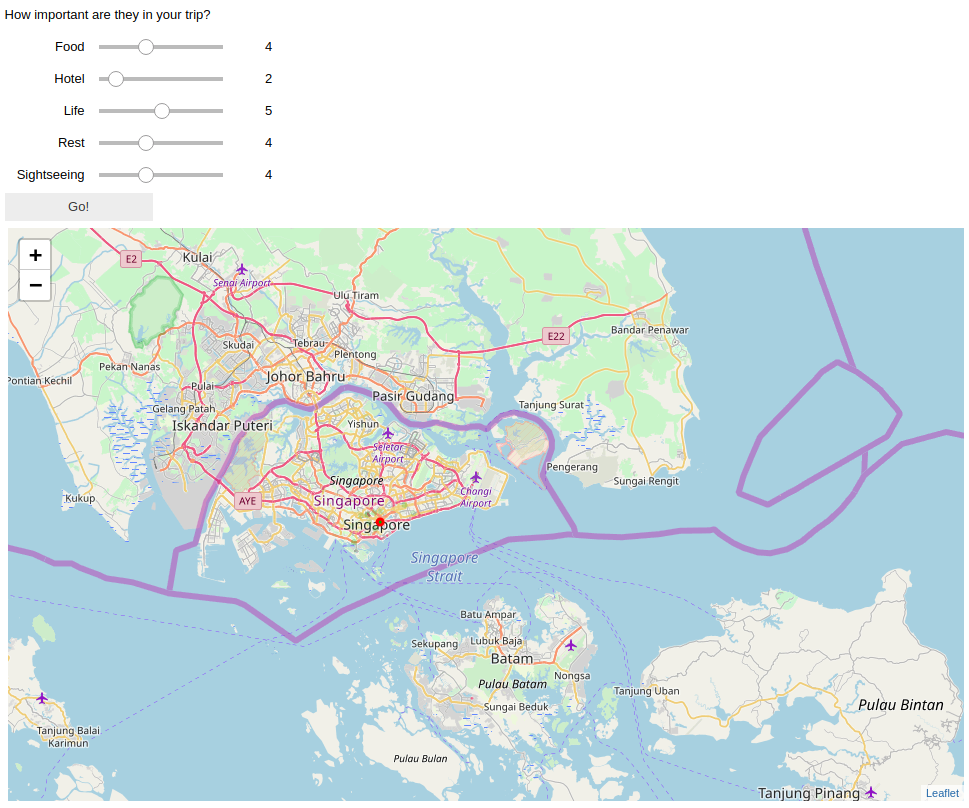
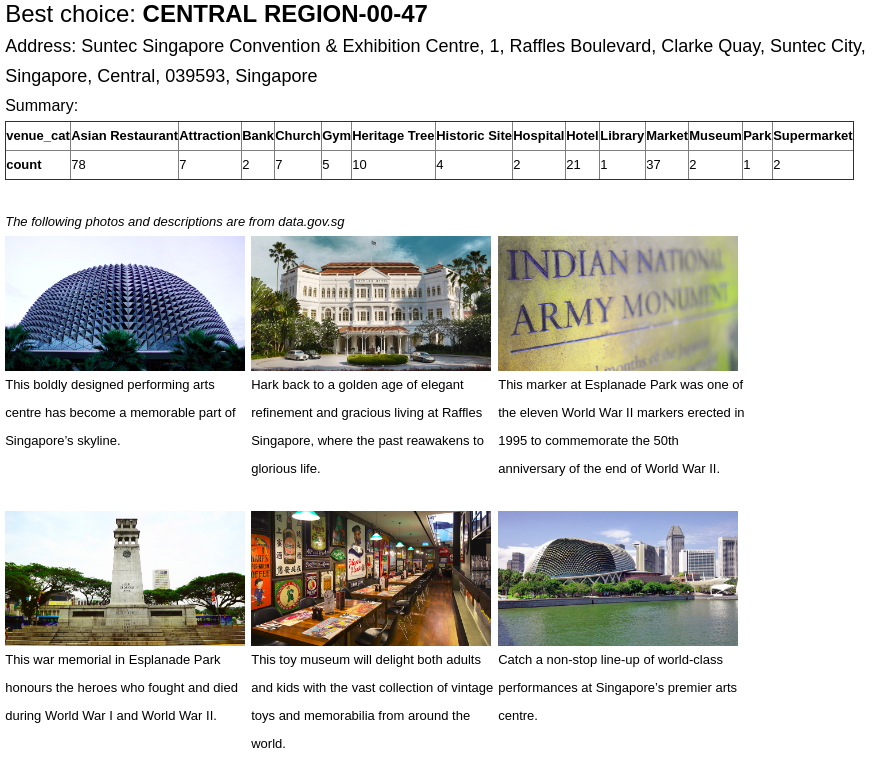
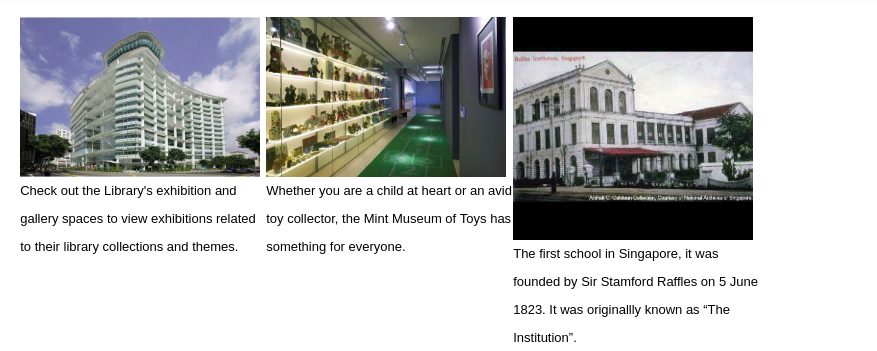
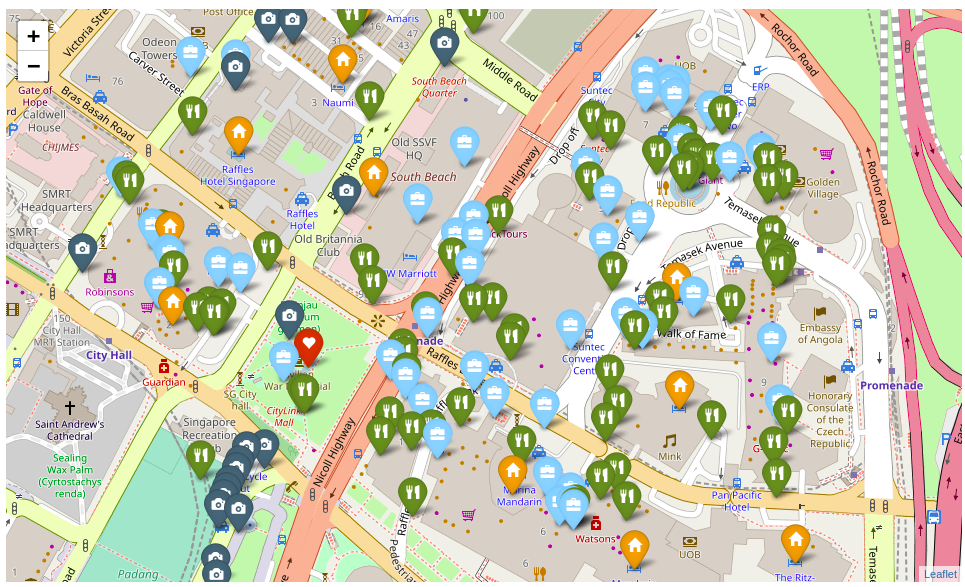
